# Human Activity Recognition Using Video


In [ ]:
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
!pip install -q kaggle
! mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d venkatkumar001/human-activity-recognition-ucf50-video-dataset

Dataset URL: https://www.kaggle.com/datasets/venkatkumar001/human-activity-recognition-ucf50-video-dataset
License(s): CC0-1.0
 99% 3.02G/3.04G [00:39<00:00, 176MB/s]
100% 3.04G/3.04G [00:40<00:00, 80.6MB/s]


In [ ]:
!unzip human-activity-recognition-ucf50-video-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: UCF50/HorseRace/v_HorseRace_g08_c02.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g08_c03.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g08_c04.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g08_c07.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g09_c01.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g09_c02.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g09_c03.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g09_c04.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g10_c01.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g10_c02.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g10_c03.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g10_c04.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g11_c01.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g11_c02.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g11_c03.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g11_c04.avi  
  inflating: UCF50/HorseRace/v_HorseRace_g11_c05.avi  
  inflating: U

In [ ]:
import os
import cv2

def extract_and_save_frames(video_path, output_folder, frame_rate=1):
    video_name = os.path.splitext(os.path.basename(video_path))[0]

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    video_capture = cv2.VideoCapture(video_path)
    fps = video_capture.get(cv2.CAP_PROP_FPS)
    frame_count = 0

    while video_capture.isOpened():
        success, frame = video_capture.read()
        if not success:
            break
        if frame_count % int(fps // frame_rate) == 0:
            frame_filename = os.path.join(output_folder, f"{video_name}_frame{frame_count}.jpg")
            cv2.imwrite(frame_filename, frame)
        frame_count += 1

    video_capture.release()

def process_all_videos_in_dict(dicti, output_base_folder, frame_rate=1):
    for label, path in dicti.items():
        # List all video files in the directory
        video_files = [f for f in os.listdir(path) if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]

        for video_file in video_files:
            video_path = os.path.join(path, video_file)
            output_folder = os.path.join(output_base_folder, label)
            extract_and_save_frames(video_path, output_folder, frame_rate)

In [ ]:
dicti={"HorseRiding":"/content/UCF50/HorseRiding",
       "PoleVault":"/content/UCF50/PoleVault",
       "Skiing":"/content/UCF50/Skiing"}

In [ ]:
output_base_folder = 'dataset'

process_all_videos_in_dict(dicti, output_base_folder, frame_rate=1)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Define the input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 3  # Since you have 3 classes: HorseRiding, PoleVault, Skiing

# Load the ResNet50 model pre-trained on ImageNet, excluding the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Add custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add global average pooling layer
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer
predictions = Dense(num_classes, activation='softmax')(x)  # Final layer for 3 classes

# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base ResNet50 layers to prevent training
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary to confirm architecture
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,688,963 (98.00 MB)

 Trainable params: 2,101,251 (8.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
model.save('resnet_model.h5')

In [ ]:
import os
import shutil

# Path to your dataset
dataset_path = 'dataset/'

# Remove .ipynb_checkpoints folders recursively
for root, dirs, files in os.walk(dataset_path):
    for dir_name in dirs:
        if dir_name == '.ipynb_checkpoints':
            shutil.rmtree(os.path.join(root, dir_name))

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [ ]:
train_generator = train_datagen.flow_from_directory(
    'dataset/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

Found 3015 images belonging to 3 classes.


In [ ]:
validation_generator = train_datagen.flow_from_directory(
    'dataset/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 753 images belonging to 3 classes.


In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5
)

Epoch 1/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 649s 7s/step - accuracy: 0.6492 - loss: 0.8235 - val_accuracy: 0.6268 - val_loss: 0.8170
Epoch 2/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 677s 7s/step - accuracy: 0.7240 - loss: 0.6818 - val_accuracy: 0.6866 - val_loss: 0.7670
Epoch 3/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 645s 7s/step - accuracy: 0.7413 - loss: 0.6426 - val_accuracy: 0.6202 - val_loss: 0.8634
Epoch 4/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 642s 7s/step - accuracy: 0.7782 - loss: 0.5837 - val_accuracy: 0.7118 - val_loss: 0.6959
Epoch 5/5
95/95 ━━━━━━━━━━━━━━━━━━━━ 644s 7s/step - accuracy: 0.7624 - loss: 0.5727 - val_accuracy: 0.5538 - val_loss: 0.9443


In [ ]:
test_loss, test_accuracy = model.evaluate(validation_generator)

24/24 ━━━━━━━━━━━━━━━━━━━━ 130s 5s/step - accuracy: 0.5690 - loss: 0.9318


# GRAD CAM

In [ ]:
import numpy as np
import tensorflow as tf
import cv2

def preprocess_image(image, size=(224, 224)):
    img = cv2.resize(image, size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

In [ ]:
def get_gradcam_heatmap(model, img_array, layer_name, class_idx=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)

        if isinstance(predictions, list):
            predictions = predictions[0]

        predictions = tf.reshape(predictions, (-1, predictions.shape[-1]))

        if class_idx is None:
            class_idx = tf.argmax(predictions, axis=-1).numpy()[0]
        class_channel = predictions[0, class_idx]

    grads = tape.gradient(class_channel, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0].numpy()
    pooled_grads = pooled_grads.numpy()

    for i in range(len(pooled_grads)):
        conv_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

In [ ]:
def overlay_heatmap_on_frame(frame, heatmap, alpha=0.4):
    heatmap_resized = cv2.resize(heatmap, (frame.shape[1], frame.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    heatmap_resized = np.float32(heatmap_resized) / 255.0

    frame_resized = np.float32(frame) / 255.0
    frame_resized = cv2.resize(frame_resized, (heatmap_resized.shape[1], heatmap_resized.shape[0]))

    overlay = heatmap_resized * alpha + frame_resized
    overlay = np.uint8(255 * overlay)

    return overlay

# SENDING A FRAME INTO MODEL AND VISUALISING THE OUTPUT OF GRADCAM

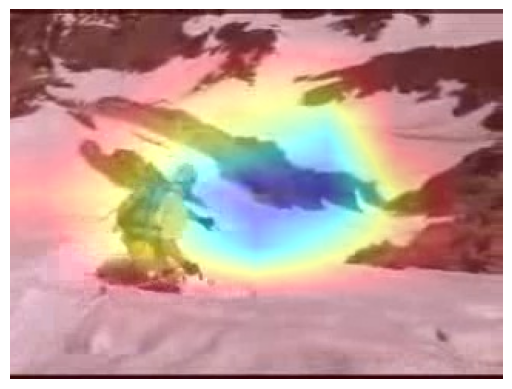

In [ ]:
image_path = '/content/dataset/Skiing/v_Skiing_g01_c01_frame25.jpg'  # Path to an image
layer_name = 'conv5_block3_out'  # Last convolutional layer in ResNet50

img_array = preprocess_image(image_path)
heatmap = get_gradcam_heatmap(model, img_array, layer_name)

# Display the Grad-CAM overlay
overlay_heatmap_on_image(image_path, heatmap)

# NOW USING VIDEO AS INPUT AND BUILDING THE OUTPUT OF GRADCAM ON OUR MODEL

In [ ]:
def process_video(input_video_path, output_video_path, model, layer_name, frame_size=(224, 224)):
    cap = cv2.VideoCapture(input_video_path)

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        img_array = preprocess_image(frame, size=frame_size)

        predictions = model.predict(img_array)
        class_idx = np.argmax(predictions[0])

        heatmap = get_gradcam_heatmap(model, img_array, layer_name, class_idx)

        frame_with_heatmap = overlay_heatmap_on_frame(frame, heatmap)

        out.write(frame_with_heatmap)

    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [ ]:
input_video_path = '/content/UCF50/HorseRiding/v_HorseRiding_g01_c02.avi'
output_video_path = 'output_video_with_heatmap.mp4'

model = tf.keras.models.load_model('resnet_model.h5')
layer_name = 'conv5_block3_out'

process_video(input_video_path, output_video_path, model, layer_name)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
import cv2
import matplotlib.pyplot as plt

def display_video_with_matplotlib(video_path):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame_rgb)
        plt.axis('off')
        plt.show(block=False)
        plt.pause(0.1)

    cap.release()
    plt.close()

video_path = '/content/output_video_with_heatmap.mp4'
display_video_with_matplotlib(video_path)


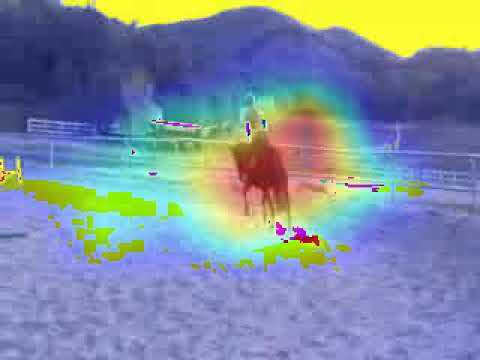

In [ ]:
from IPython import display
display.YouTubeVideo("5SuTAA1gQYM")